In [1]:
#importing important Libraries

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import sys
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,precision_recall_curve, roc_auc_score, roc_curve


# Reading the Data and EDA

In [2]:
dataset = pd.read_csv('../input/resized-2015-2019-blindness-detection-images/labels/trainLabels19.csv')

dataset

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0
...,...,...
3657,ffa47f6a7bf4,2
3658,ffc04fed30e6,0
3659,ffcf7b45f213,2
3660,ffd97f8cd5aa,0


0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64


<AxesSubplot:ylabel='diagnosis'>

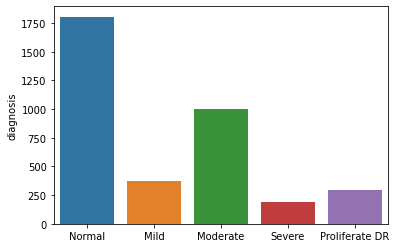

In [3]:
# value count of classes
names = ['Normal', 'Mild', 'Moderate', 'Severe', 'Proliferate DR']
print(dataset['diagnosis'].value_counts())
sns.barplot(x=names,y=dataset.diagnosis.value_counts().sort_index())

In [4]:
dataset1 = pd.read_csv('../input/resized-2015-2019-blindness-detection-images/labels/trainLabels15.csv')
dataset1.columns = ['id_code','diagnosis']
dataset1

,id_code,diagnosis
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
...,...,...
35121,44347_right,0
35122,44348_left,0
35123,44348_right,0
35124,44349_left,0


0    25810
2     5292
1     2443
3      873
4      708
Name: diagnosis, dtype: int64


<AxesSubplot:ylabel='diagnosis'>

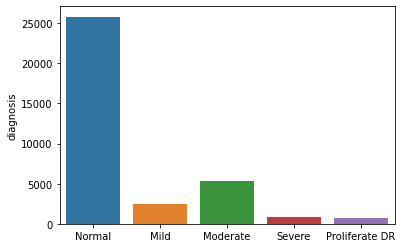

In [5]:
print(dataset1['diagnosis'].value_counts())
sns.barplot(x=names,y=dataset1.diagnosis.value_counts().sort_index())

In [6]:
#Now we will take 900 images in total for each class. So to complete the 900 images we will take majority of images from 'dataset' 
#and if take the rest of the required images from 'dataset1'

#index  Final_Img_count   Image taken from dataset 1
# 0          900                   (0)
# 1          900                 (530)
# 2          900                   (0)
# 3          900                 (707)
# 4          900                 (605)


level_1 = dataset1[dataset1.diagnosis == 1].sample(n=530)

level_3 = dataset1[dataset1.diagnosis == 3].sample(n=707)

level_4 = dataset1[dataset1.diagnosis == 4].sample(n=605)

In [7]:
level_1.shape , level_3.shape, level_4.shape

((530, 2), (707, 2), (605, 2))

In [8]:
level_0 = dataset[dataset.diagnosis == 0].sample(n=900)
level_0

,id_code,diagnosis
112,08b6e3240858,0
119,0924cec998fa,0
3193,de55ed25e0e8,0
2344,a4012932e18d,0
3364,e97ecf4355cb,0
...,...,...
229,10f10fd30718,0
3336,e77a93c3d9a9,0
130,09c8323c612e,0
1598,705f508d1e42,0


In [9]:
level_2 = dataset[dataset.diagnosis == 2].sample(n=900)
level_2

,id_code,diagnosis
1126,4f20f9a9a65b,2
195,0e75d51152fc,2
2022,8e3b79e1f1f7,2
2126,959dc602febc,2
3249,e1e490773462,2
...,...,...
2194,9a3c03a5ad0f,2
813,3aa2b1ce6700,2
1087,4d1cf360b2d7,2
2158,98104c8c67eb,2


In [10]:
dataset= dataset[dataset['diagnosis']>0]
dataset= dataset[dataset['diagnosis'] != 2]
print(dataset['diagnosis'].value_counts())

1    370
4    295
3    193
Name: diagnosis, dtype: int64


In [11]:
dataset = pd.concat([level_0,level_2,dataset])
dataset=dataset.sample(frac=1)
print(dataset['diagnosis'].value_counts())
dataset

2    900
0    900
1    370
4    295
3    193
Name: diagnosis, dtype: int64


,id_code,diagnosis
1513,6a91eb157f47,2
3376,ea588d1e5d96,2
1085,4d167ca69ea8,0
3428,ee3f5cf52188,0
2996,d0926ed2c8e5,0
...,...,...
3078,d66b6f333dc7,1
227,10ecc5292ab1,2
1236,55eac26bd383,1
209,0fb1053285cf,1


In [12]:
dataset1 = pd.concat([level_1,level_3, level_4])
dataset1=dataset1.sample(frac=1)

print(dataset1['diagnosis'].value_counts())
dataset1

3    707
4    605
1    530
Name: diagnosis, dtype: int64


,id_code,diagnosis
31116,39343_left,1
7493,9450_right,3
17372,21825_left,3
19687,24853_right,4
18931,23884_right,3
...,...,...
20115,25378_right,4
3814,4781_left,1
824,1002_left,3
34462,43552_left,1


In [13]:
#reading Image files
#tqdm for visualisation purpose
images = []
for i, image_id in enumerate(tqdm(dataset.id_code)):
    im = cv2.imread(f'../input/resized-2015-2019-blindness-detection-images/resized train 19/{image_id}.jpg')
    im = cv2.resize(im, (128, 128))    # resizing images as 128*128
    images.append(im)

# images

100%|██████████| 2658/2658 [00:57<00:00, 46.03it/s]


In [14]:
for i, image_id in enumerate(tqdm(dataset1.id_code)):
    im = cv2.imread(f'../input/resized-2015-2019-blindness-detection-images/resized train 15/{image_id}.jpg')
    im = cv2.resize(im, (128, 128))
    images.append(im)

# images

100%|██████████| 1842/1842 [00:46<00:00, 39.93it/s]


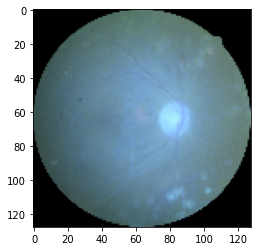

In [15]:
# random image from imported data
plt.imshow(images[-30])
plt.show()

In [16]:
# This function will act as a filter for the image data
#cv2.addWeighted(source1, alpha, source2, beta, gamma[, dst[, dtype]]

def load_colorfilter(image, sigmaX=10):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)           #changing color of image
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX),-4 ,128)  # applying image cleaning process
    return image

In [17]:
# converting all images as preprocessed defination
for i in range(len(images)):
    output = load_colorfilter(images[i])
    images[i] = output

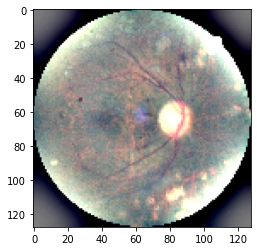

In [18]:
# image after filtering
plt.imshow(images[-30])
plt.show()

In [19]:
# checking the shape of data
images = np.array(images)
images.shape

(4500, 128, 128, 3)

2    900
0    900
3    900
4    900
1    900
Name: diagnosis, dtype: int64


<AxesSubplot:ylabel='diagnosis'>

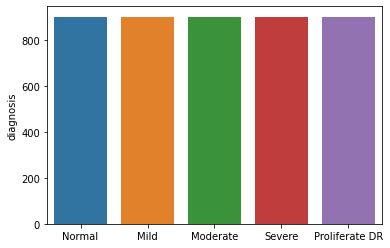

In [20]:
#concatinating all the data into dataset data frame
dataset = pd.concat([dataset,dataset1])
print(dataset['diagnosis'].value_counts())

sns.barplot(x=names,y=dataset.diagnosis.value_counts().sort_index())

In [21]:
#normalizing the images arrays
X = images/255.0
y = dataset.diagnosis.values   #it will return an array of labels like array([4, 0, 4, ..., 1, 4, 1]))
X, y

(array([[[[0.28235294, 0.39215686, 0.45490196],
          [0.28235294, 0.39215686, 0.45490196],
          [0.28235294, 0.37647059, 0.45490196],
          ...,
          [0.15686275, 0.31372549, 0.45490196],
          [0.17254902, 0.32941176, 0.45490196],
          [0.17254902, 0.32941176, 0.45490196]],
 
         [[0.28235294, 0.39215686, 0.45490196],
          [0.28235294, 0.39215686, 0.45490196],
          [0.28235294, 0.37647059, 0.45490196],
          ...,
          [0.15686275, 0.31372549, 0.45490196],
          [0.17254902, 0.32941176, 0.47058824],
          [0.17254902, 0.32941176, 0.45490196]],
 
         [[0.28235294, 0.39215686, 0.45490196],
          [0.28235294, 0.39215686, 0.45490196],
          [0.25098039, 0.37647059, 0.43921569],
          ...,
          [0.15686275, 0.31372549, 0.45490196],
          [0.15686275, 0.31372549, 0.45490196],
          [0.15686275, 0.31372549, 0.45490196]],
 
         ...,
 
         [[0.39215686, 0.43921569, 0.47058824],
          [0.39215

In [22]:
# Cleaning some RAM memory space
del images,level_1,level_3, level_4, level_0, dataset1

In [23]:
# Applying image augmentation
sys.stdout.flush()   # forces it to "flush" the buffer, meaning that it will write everything in the buffer to the terminal, even if normally it would wait before doing so.
aug = ImageDataGenerator(rotation_range=0.2, width_shift_range=0.2, \
    height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,\
    horizontal_flip=True, fill_mode="nearest")

In [24]:
#train test split
X, X_test, y, y_test = train_test_split(X,y,test_size=0.1, stratify = y)
X.shape, X_test.shape, y.shape, y_test.shape

((4050, 128, 128, 3), (450, 128, 128, 3), (4050,), (450,))

In [25]:
# Function defined to plot the curves during training

def display_training_curves(training, validation, title, subplot):
    
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])
    plt.show()

In [26]:
from tensorflow.keras.applications.resnet50 import ResNet50
restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

2022-11-16 04:51:18.883382: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 04:51:19.038772: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 04:51:19.039648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 04:51:19.041116: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 3s 0us/step


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-11-16 04:51:27.440907: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-11-16 04:51:33.323805: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


64/64 [==============================] - 24s 200ms/step - loss: 2.0467 - acc: 0.2701 - val_loss: 1.9496 - val_acc: 0.1926
Epoch 2/100
64/64 [==============================] - 11s 166ms/step - loss: 1.6456 - acc: 0.3664 - val_loss: 4.7481 - val_acc: 0.2000
Epoch 3/100
64/64 [==============================] - 10s 161ms/step - loss: 1.4829 - acc: 0.4272 - val_loss: 7.7550 - val_acc: 0.2000
Epoch 4/100
64/64 [==============================] - 12s 185ms/step - loss: 1.3493 - acc: 0.4726 - val_loss: 8.1804 - val_acc: 0.2000
Epoch 5/100
64/64 [==============================] - 10s 162ms/step - loss: 1.3011 - acc: 0.4849 - val_loss: 7.0786 - val_acc: 0.2000
Epoch 6/100
64/64 [==============================] - 10s 160ms/step - loss: 1.2146 - acc: 0.5180 - val_loss: 5.7878 - val_acc: 0.2025
Epoch 7/100
64/64 [==============================] - 10s 161ms/step - loss: 1.1764 - acc: 0.5373 - val_loss: 3.6091 - val_acc: 0.1936
Epoch 8/100
64/64 [==============================] - 10s 159ms/step - loss

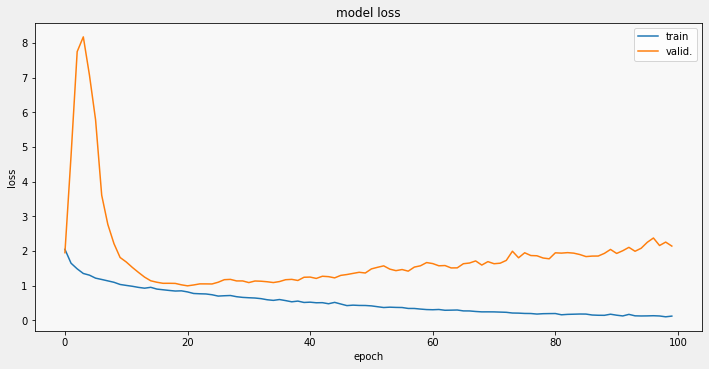

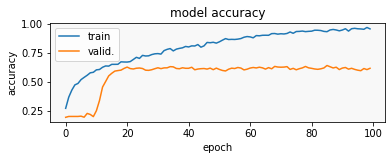

Epoch 1/100
64/64 [==============================] - 17s 194ms/step - loss: 1.5000 - acc: 0.3980 - val_loss: 0.7701 - val_acc: 0.6953
Epoch 2/100
64/64 [==============================] - 11s 167ms/step - loss: 1.1435 - acc: 0.5560 - val_loss: 0.6116 - val_acc: 0.7575
Epoch 3/100
64/64 [==============================] - 10s 159ms/step - loss: 1.0119 - acc: 0.6059 - val_loss: 0.5506 - val_acc: 0.7788
Epoch 4/100
64/64 [==============================] - 10s 162ms/step - loss: 0.9151 - acc: 0.6509 - val_loss: 0.5480 - val_acc: 0.7817
Epoch 5/100
64/64 [==============================] - 11s 166ms/step - loss: 0.8727 - acc: 0.6523 - val_loss: 0.5209 - val_acc: 0.7951
Epoch 6/100
64/64 [==============================] - 10s 161ms/step - loss: 0.8396 - acc: 0.6825 - val_loss: 0.5149 - val_acc: 0.7941
Epoch 7/100
64/64 [==============================] - 10s 160ms/step - loss: 0.7955 - acc: 0.6785 - val_loss: 0.4864 - val_acc: 0.8104
Epoch 8/100
64/64 [==============================] - 10s 163ms

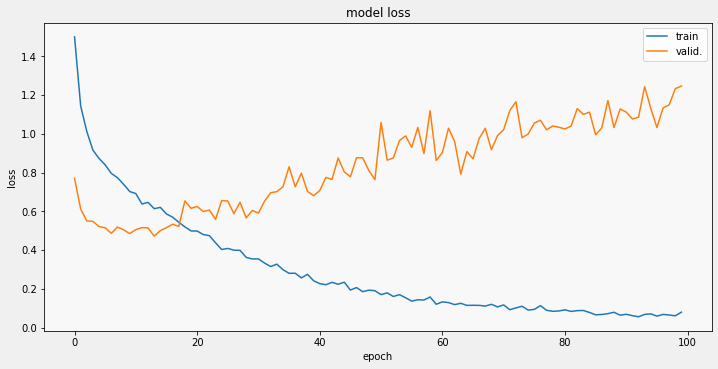

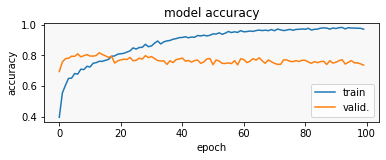

In [27]:
BS = 32       #Batch size
accuracy = []

############ USING STRATIFIED K-FOLD CROSS VALIDATION TECHNIQUE ##########

skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X,y)

for train, test in skf.split(X,y):
    model2 = tf.keras.Sequential([
        restnet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    
    # Compiling the model
    model2.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001),loss='sparse_categorical_crossentropy',metrics=['acc'])
    
    # Training
    history = model2.fit_generator(aug.flow(X[train], y[train], batch_size=BS),
    validation_data=(X[test], y[test]),
    epochs=100, verbose = 1)

    # Evaluate score
    acc=model2.evaluate(X[test], y[test])
    accuracy.append(acc[1])
    
    # Plotting traning curves
    display_training_curves(
    history.history['loss'], 
    history.history['val_loss'], 
    'loss', 211)
    
    display_training_curves(
    history.history['acc'], 
    history.history['val_acc'], 
    'accuracy', 212)

In [28]:
accuracy

[0.6158024668693542, 0.736790120601654]

In [29]:
# thus we can assume the mean accuracy of the model on the training set to be:
a=sum(accuracy)/len(accuracy)
print(f'Mean evaluated accuracy of model : {a}')

Mean evaluated accuracy of model : 0.6762962937355042


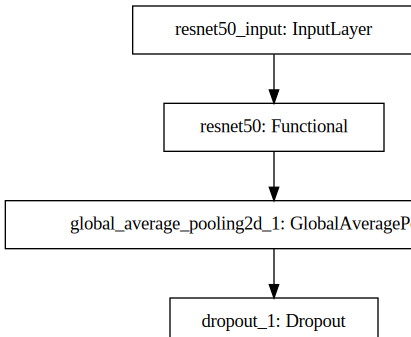

In [30]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model2).create(prog='dot', format='svg'))

In [31]:
#predicting training labels
y_train_pred = model2.predict(X)
y_train_pred=np.argmax(y_train_pred,axis=1)   #argmax with axis 1 so it will return index of which row got the maximum value
print(y_train_pred,y)
#Accuracy of train prediction
print('\nAccuracy of training data prediction : {:.2f}\n'.format(accuracy_score(y, y_train_pred)))

#confusion matrix for training set
confusion = confusion_matrix(y, y_train_pred)
print('Confusion Matrix of training data prediction \n')
print(confusion)

2022-11-16 05:27:52.051796: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 796262400 exceeds 10% of free system memory.
2022-11-16 05:27:52.987809: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 796262400 exceeds 10% of free system memory.


[3 0 1 ... 4 0 4] [3 0 1 ... 3 0 3]

Accuracy of training data prediction : 0.85

Confusion Matrix of training data prediction 

[[784  25   0   0   1]
 [ 10 782   8   6   4]
 [  9 167 599  20  15]
 [  1 146  22 600  41]
 [  2  61  20  68 659]]


In [32]:
y_train_pred1 = model2.predict(X)
y_train_pred0=np.argmax(y_train_pred1,axis=1)
y_train_pred0,y_train_pred1

2022-11-16 05:27:57.646720: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 796262400 exceeds 10% of free system memory.
2022-11-16 05:27:58.577296: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 796262400 exceeds 10% of free system memory.


(array([3, 0, 1, ..., 4, 0, 4]),
 array([[9.7751850e-04, 2.0219671e-02, 7.5344033e-05, 9.0272671e-01,
         7.6000758e-02],
        [9.9898678e-01, 1.0132520e-03, 1.6423940e-09, 2.4702564e-09,
         4.3574286e-09],
        [9.3542610e-07, 9.9999857e-01, 8.2584446e-09, 3.3177415e-07,
         1.1349348e-07],
        ...,
        [9.4865885e-05, 1.1069665e-02, 1.1429377e-04, 2.1580342e-02,
         9.6714079e-01],
        [9.9999964e-01, 3.2529539e-07, 2.6995954e-09, 3.7714449e-09,
         2.4399222e-10],
        [4.4763670e-04, 4.5945370e-03, 3.2786453e-01, 1.2876289e-02,
         6.5421695e-01]], dtype=float32))

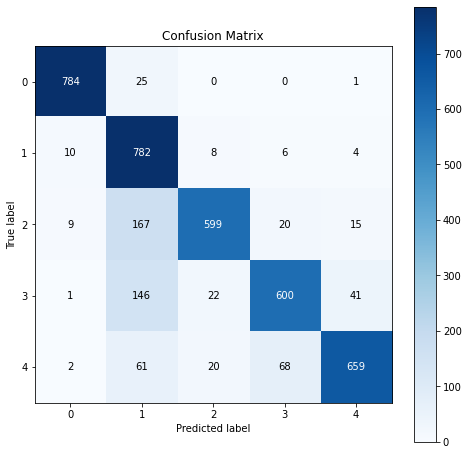

In [33]:
# Visualizing confusion matrix for train data
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y, y_train_pred, figsize=(8, 8))
plt.show()

ROC AUC score for train: 0.9033950617283949


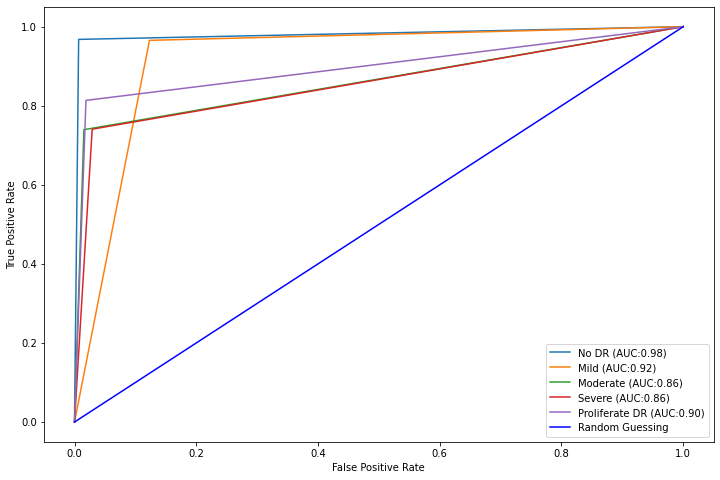

In [34]:
# Curve of the individual target.

import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferate DR']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score for train:', multiclass_roc_auc_score(y, y_train_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [35]:
#Classification report 
print('\nClassification Report of training set : \n')
print(classification_report(y, y_train_pred, target_names=['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferate DR']))



Classification Report of training set : 

                precision    recall  f1-score   support

         No DR       0.97      0.97      0.97       810
          Mild       0.66      0.97      0.79       810
      Moderate       0.92      0.74      0.82       810
        Severe       0.86      0.74      0.80       810
Proliferate DR       0.92      0.81      0.86       810

      accuracy                           0.85      4050
     macro avg       0.87      0.85      0.85      4050
  weighted avg       0.87      0.85      0.85      4050



In [36]:
y_pred = model2.predict(X_test)

y_pred=np.argmax(y_pred,axis=1)

In [37]:
y_pred

array([1, 1, 1, 4, 1, 3, 1, 2, 3, 1, 1, 0, 0, 2, 1, 1, 3, 4, 0, 1, 1, 1,
       4, 4, 0, 1, 0, 1, 0, 1, 1, 0, 4, 3, 1, 4, 3, 3, 3, 3, 2, 2, 2, 1,
       4, 0, 1, 1, 1, 3, 4, 0, 0, 2, 2, 0, 4, 1, 4, 0, 1, 1, 2, 1, 0, 1,
       1, 3, 4, 3, 2, 1, 1, 0, 0, 4, 1, 0, 4, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 3, 0, 1, 1, 3, 1, 1, 0, 3, 0, 2, 4, 2, 2, 1, 3, 4, 4, 4, 4, 0,
       3, 1, 2, 3, 1, 1, 2, 3, 1, 4, 1, 0, 1, 3, 1, 4, 4, 3, 1, 2, 1, 3,
       2, 1, 4, 0, 3, 4, 1, 1, 1, 0, 0, 0, 1, 1, 1, 2, 3, 3, 2, 1, 0, 1,
       2, 3, 1, 1, 0, 1, 1, 2, 2, 2, 4, 0, 0, 3, 0, 1, 0, 1, 4, 3, 1, 0,
       3, 1, 2, 3, 2, 1, 4, 1, 1, 4, 3, 1, 3, 0, 1, 1, 3, 4, 0, 0, 2, 1,
       3, 1, 2, 1, 1, 1, 0, 3, 1, 1, 0, 1, 1, 2, 1, 3, 4, 2, 1, 0, 2, 1,
       0, 3, 0, 1, 1, 0, 1, 4, 4, 2, 2, 2, 1, 0, 0, 1, 0, 1, 3, 1, 1, 4,
       3, 1, 4, 0, 0, 0, 2, 0, 3, 4, 0, 1, 4, 2, 1, 1, 1, 2, 3, 3, 1, 4,
       3, 1, 0, 4, 3, 3, 1, 3, 2, 4, 2, 1, 1, 1, 4, 2, 3, 1, 0, 1, 3, 1,
       1, 2, 2, 0, 3, 3, 1, 1, 0, 1, 3, 4, 1, 1, 0,

In [38]:
y_test

array([2, 1, 1, 3, 4, 2, 3, 3, 2, 1, 2, 0, 0, 2, 1, 4, 3, 4, 0, 1, 1, 2,
       4, 4, 0, 1, 0, 1, 0, 1, 4, 0, 4, 3, 4, 3, 2, 3, 4, 3, 2, 2, 2, 1,
       4, 0, 0, 3, 1, 4, 4, 0, 0, 2, 2, 0, 4, 2, 4, 0, 1, 4, 2, 1, 0, 1,
       1, 1, 3, 3, 1, 1, 2, 0, 0, 4, 1, 0, 4, 0, 1, 4, 2, 0, 2, 0, 3, 1,
       3, 4, 0, 2, 1, 3, 4, 1, 0, 3, 0, 2, 4, 2, 2, 3, 3, 4, 4, 4, 3, 0,
       2, 1, 2, 3, 1, 3, 2, 2, 1, 3, 1, 0, 1, 4, 1, 4, 4, 4, 4, 2, 1, 4,
       2, 1, 1, 0, 4, 4, 1, 3, 2, 2, 2, 0, 3, 3, 1, 2, 3, 4, 3, 3, 0, 4,
       2, 3, 4, 1, 0, 1, 1, 2, 2, 2, 4, 0, 0, 3, 0, 3, 0, 2, 4, 4, 1, 0,
       3, 1, 2, 3, 2, 2, 4, 1, 2, 4, 3, 1, 3, 0, 3, 1, 3, 4, 0, 0, 4, 1,
       3, 1, 2, 3, 3, 1, 0, 3, 1, 1, 0, 4, 1, 2, 4, 3, 4, 4, 4, 0, 2, 1,
       0, 4, 0, 2, 1, 0, 1, 2, 4, 2, 1, 2, 2, 0, 0, 1, 0, 1, 3, 1, 1, 4,
       3, 1, 4, 0, 0, 0, 2, 0, 4, 4, 0, 2, 4, 2, 3, 1, 1, 2, 4, 3, 3, 4,
       3, 2, 0, 3, 3, 3, 0, 3, 1, 4, 2, 1, 1, 1, 4, 2, 4, 3, 0, 3, 3, 2,
       1, 2, 4, 0, 4, 3, 1, 1, 0, 3, 4, 4, 1, 1, 0,

In [39]:
# Accuracy of test prediction
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))


Accuracy: 0.68



In [40]:
# Confusion matrix of the test data
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[85  5  0  0  0]
 [ 2 82  3  2  1]
 [ 2 29 47  8  4]
 [ 0 29  3 44 14]
 [ 0 20  5 19 46]]


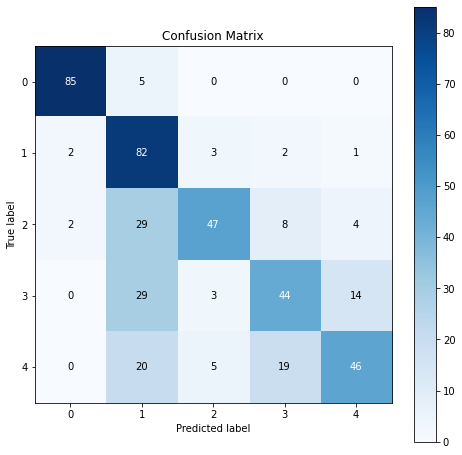

In [41]:
# Visualizing confusion matrix for test data
skplt.metrics.plot_confusion_matrix(y_test, y_pred, figsize=(8, 8))
plt.show()

In [42]:
#Classification report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferate DR']))


Classification Report

                precision    recall  f1-score   support

         No DR       0.96      0.94      0.95        90
          Mild       0.50      0.91      0.64        90
      Moderate       0.81      0.52      0.64        90
        Severe       0.60      0.49      0.54        90
Proliferate DR       0.71      0.51      0.59        90

      accuracy                           0.68       450
     macro avg       0.71      0.68      0.67       450
  weighted avg       0.71      0.68      0.67       450



ROC AUC score for test: 0.7972222222222222


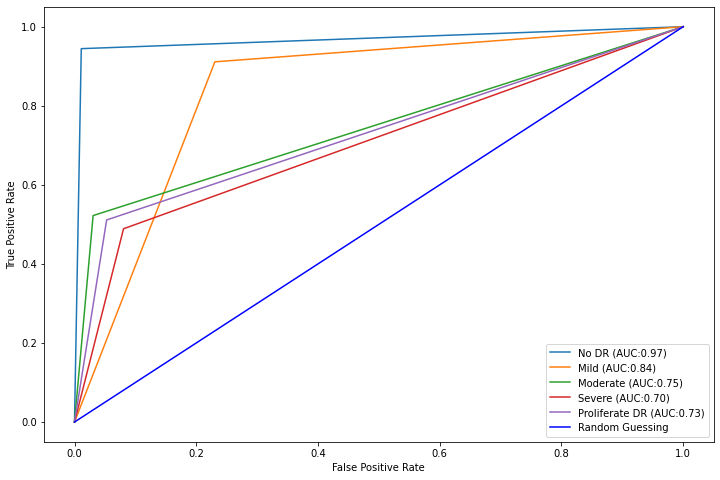

In [43]:
# Curve of the individual target.

import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferate DR']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score for test:', multiclass_roc_auc_score(y_test, y_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()